# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548]),
 array([ 0.        ,  0.39594954,  0.27878635, ..., -0.55344109,
        -0.71057181, -0.62256885])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
# out_spikes

## Model Fitting

In [6]:
model = '''
        dv/dt = (R*I- v)/tau : 1
        dvt/dt = (a*v - vt) / taut :1
        alpha : 1 (constant)
        a : 1 (constant)
        R : 1/amp (constant)
        tau : second (constant)
        taut : second (constant)
        D: second (constant)
        '''

reset = '''
v = 0
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel3', clean=False)

In [8]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=50*second, delta=4*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=400,
                     threshold='v > 1 + vt',
                     reset=reset,
                     refractory='D',
                     )

exponential_euler


In [10]:
result_dict, error = fitter.fit(n_rounds=20,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[0.1, 2.2],
                                a = [0.01, 0.1],
                                R = [1, 15] * 1/nA, 
                                tau = [7, 20]*ms,
                                taut = [30, 100]*ms,
                                D = [0.1, 3]*ms
                               )

Round 0: fit (0.0525861073546059, 0.01656401963506375, 0.7893614201519519, 11107306680.83321, 0.0424225939460832, 0.0016590522002578063) with error: 0.027077476355685942
Round 1: fit (0.0460712447508277, 0.0176004395368781, 0.948207194178683, 12360770196.0368, 0.02692612903092512, 0.0022186217148336303) with error: 0.015419959724266685
Round 2: fit (0.040922270411232656, 0.01853331385809208, 1.1238445684883334, 13220831568.886703, 0.07451931862531054, 0.001539537150282133) with error: 0.01169391649316287
Round 3: fit (0.040922270411232656, 0.01853331385809208, 1.1250620716296877, 13220831568.886703, 0.08272262539036146, 0.001539537150282133) with error: 0.006838357150666274
Round 4: fit (0.040922270411232656, 0.01853331385809208, 1.1250620716296877, 13220831568.886703, 0.08272262539036146, 0.001539537150282133) with error: 0.006838357150666274
Round 5: fit (0.040922270411232656, 0.01853331385809208, 1.1250620716296877, 13220831568.886703, 0.08272262539036146, 0.001539537150282133) with

In [11]:
result_dict

{'taut': 0.03940264530424703,
 'tau': 0.019428036380643388,
 'alpha': 1.0694762113655902,
 'R': 13154191074.086367,
 'a': 0.09021720088860954,
 'D': 0.00047695430996046867}

In [12]:
print('a', result_dict['a'])
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', result_dict['R'])
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', result_dict['alpha'])

a 0.09021720088860954
tau 19.42803638 ms
R 13154191074.086367
taut 39.4026453 ms
alpha 1.0694762113655902


In [13]:
error

0.002284389203356718

In [14]:
1 - error

0.9977156107966433

In [15]:
device.reinit()
device.activate()

In [16]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

exponential_euler


In [17]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
1064


In [18]:
print(len(out_spikes[1]))
print(len(spikes[1]))

1505
0


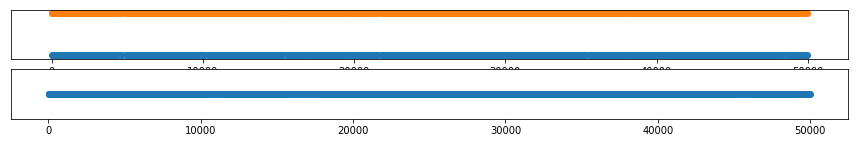

In [19]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

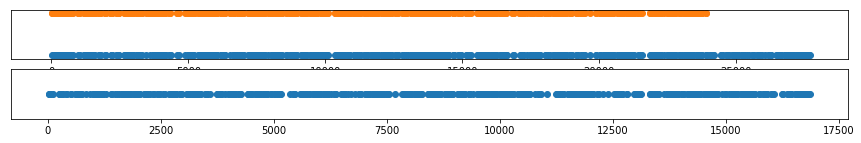

In [20]:
d=500


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [21]:
device.reinit()
device.activate()

In [22]:
fits = fitter.generate(params=None, output_var='v',)

exponential_euler


In [23]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [24]:
t

array([   9.89,   15.01,   85.69,  151.83,  176.66,  205.11,  254.71,
        289.26,  321.97,  368.84,  411.06,  499.43,  506.81,  521.07,
        580.54,  589.33,  617.56,  660.08,  708.29,  784.89,  967.35,
        974.27, 1029.85, 1178.93, 1197.49, 1276.81, 1312.62, 1317.32,
       1374.22, 1406.75, 1420.81, 1461.91, 1483.74, 1513.86, 1596.68,
       1599.62, 1716.13, 1731.97, 1814.26, 1942.39, 1958.71, 1985.08,
       2124.22, 2177.84, 2181.07, 2211.95, 2219.27, 2344.79, 2416.97,
       2421.76, 2427.31, 2450.53, 2649.  , 2684.94, 2726.19, 2790.85,
       2811.27, 2857.67, 2862.95, 2886.  , 2922.6 , 2975.14, 2986.36])

In [25]:
os = array(out_spikes[0])
os[os<3000]

array([  10.85,   86.77,  152.87,  177.99,  206.49,  255.46,  289.97,
        351.57,  372.45,  411.88,  501.64,  514.26,  569.2 ,  588.26,
        617.37,  659.91,  705.57,  796.7 ,  968.93, 1029.32, 1179.85,
       1201.26, 1277.75, 1314.76, 1374.47, 1408.51, 1422.03, 1462.08,
       1485.98, 1514.33, 1597.82, 1717.75, 1744.83, 1814.92, 1943.69,
       1985.12, 2178.47, 2198.5 , 2217.57, 2345.9 , 2418.41, 2427.14,
       2450.77, 2650.41, 2686.33, 2729.71, 2792.29, 2818.29, 2859.09,
       2884.83, 2922.46, 2975.51, 2988.59])

In [26]:
v = fits[0]
d = 300000

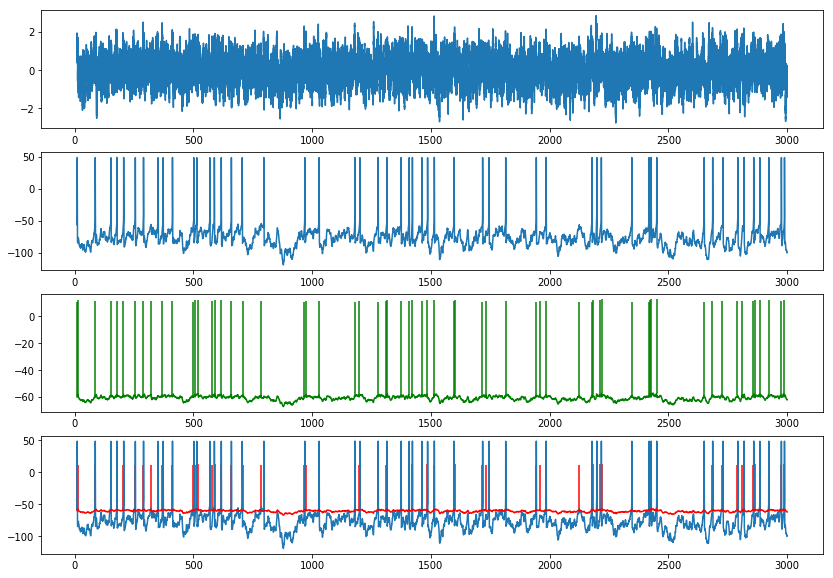

In [27]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'g');

ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[3].plot(t0[1000:d]/ms, v[1000:d]-60, 'r')
ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'r');



In [ ]:
plt.figure(figsize=(20,10))
plot(t0[55000:d]/ms, voltage1[55000:d]);
plot(t0[55000:d]/ms, v[55000:d]-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]+60, v[np.int_(np.round(t/dt*ms))]-60, 'r');


In [1]:
# store all results
parameters_df = fitter.results(format='dataframe')
parameters_df.to_csv('aif_best.csv')

NameError: name 'fitter' is not defined